# Fatima Fellowship Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. These coding challenges are not meant to take too long, do NOT spend more than 4-6 hours on them -- you can submit whatever you have.

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook along with your application. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw)



---


### **Important**: Beore you get started, please make sure to make a **copy of this notebook** and set sharing permissions so that **anyone with the link can view**. Otherwise, we will NOT be able to assess your application.



---



# 1. Deep Learning for Vision

**Generated by AI detector**: Train a model to detect if images are generated by AI

* Find a dataset of natural images and images generated by AI (here is one such dataset on the [Hugging Face Hub](https://huggingface.co/datasets/competitions/aiornot) but you're welcome to use any dataset you've found.
* Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify the image as being generated by an AI or not until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

In [ ]:
import huggingface_hub
huggingface_hub.notebook_login()

In [1]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE
import torch
from tqdm.notebook import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


dataset = load_dataset("competitions/aiornot", split="train")
dataset = dataset.train_test_split(test_size=0.2)

train_dataset = dataset['train']
train_dataset = train_dataset.with_format("torch")

test_dataset = dataset['test']
test_dataset = test_dataset.with_format("torch")


Found cached dataset parquet (/home/asebaq/.cache/huggingface/datasets/competitions___parquet/competitions--aiornot-f559c639a48093b2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [2]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=1)

## Dataset stats

In [3]:

psum = torch.zeros((1, 3))
psum_sq = torch.zeros((1, 3))

# loop through images
for batch in tqdm(train_dataloader):
    imgs = batch['image']
    imgs = imgs.float()/255.0
    imgs = torch.permute(imgs, (0, 3, 1, 2))
    psum += imgs.sum(axis=[0, 2, 3])
    psum_sq += (imgs ** 2).sum(axis=[0, 2, 3])

# pixel count
count = len(train_dataloader) * 32 * 512**2

# mean and std
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean ** 2)
total_std = torch.sqrt(total_var)

  0%|          | 0/466 [00:00<?, ?it/s]

In [4]:
total_mean, total_var, total_std

(tensor([[0.4850, 0.4348, 0.3922]]),
 tensor([[0.0839, 0.0806, 0.0814]]),
 tensor([[0.2897, 0.2839, 0.2852]]))

## Model

In [5]:
from torch import nn
from torchmetrics.classification import BinaryAccuracy
from torch.utils.tensorboard import SummaryWriter


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


class Discriminator(nn.Module):
    def __init__(self, img_size, in_channels):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.in_channels = in_channels

        def _block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *_block(self.in_channels, 16, bn=False),
            *_block(16, 32),
            *_block(32, 64),
            *_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = self.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        #out = out.view(out.shape[0], -1)
        out = torch.reshape(out, (out.shape[0], -1))
        validity = self.adv_layer(out)

        return validity


## Training

In [6]:
def train(epoch, dataloader, device, model, optimizer):
    normalize = transforms.Normalize(total_mean, total_std)

    criterion = torch.nn.BCELoss()
    metric = BinaryAccuracy()
    metric.to(device)  

    # Initialize weights
    model.apply(weights_init_normal)
    model.to(device)
    
    total_loss = 0.0
    total_acc = 0.0
    for j in range(epoch):
        for batch in tqdm(dataloader):
            
            # Configure input
            imgs = batch['image']
            imgs = imgs.float()
            imgs = normalize(imgs)
            imgs = torch.permute(imgs, (0, 3, 1, 2))
            imgs = imgs.to(device)
            
            lbls = batch['label']
            lbls = lbls.float()
            lbls = torch.unsqueeze(lbls, 1)
            lbls = lbls.to(device)

            # Train Discriminator
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, lbls)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.detach().cpu()
            total_acc += metric(pred.detach(), lbls)
        
        total_loss /= len(dataloader)
        total_acc /= len(dataloader)
        
        # logging
        writer.add_scalar('Train/loss', total_loss, j)
        writer.add_scalar('Train/acc', total_acc, j)

        if (j + 1) % 5 == 0:
            print(f"Epoch {j + 1} / loss: {total_loss:.4f} / acc: {total_acc*100:.4f}")
        

In [7]:
epochs = 50
lr = 1e-3
writer = SummaryWriter()
model = Discriminator(512, 3)
optimizer = torch.optim.Adam(model.parameters(), lr)
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')

In [8]:
train(epochs, train_dataloader, device, model, optimizer)

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 5 / loss: 0.2896 / acc: 87.5827


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 10 / loss: 0.1710 / acc: 93.3498


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 15 / loss: 0.1140 / acc: 95.9526


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 20 / loss: 0.0814 / acc: 97.5260


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 25 / loss: 0.0620 / acc: 98.0448


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 30 / loss: 0.0523 / acc: 98.7227


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 35 / loss: 0.0472 / acc: 98.7099


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 40 / loss: 0.0362 / acc: 99.0657


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 45 / loss: 0.0317 / acc: 99.1263


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 50 / loss: 0.0299 / acc: 99.2340


In [9]:
torch.save(model, 'model.pt')

## Test

In [10]:
def test(dataloader, device, model):
    normalize = transforms.Normalize(total_mean, total_std)
    model.to(device)
    model.eval()
    acc = 0.0
    metric = BinaryAccuracy()
    metric.to(device)  
    
    for i, batch in enumerate(tqdm(dataloader)):
        # Configure input
        imgs = batch['image']
        imgs = imgs.float()
        imgs = normalize(imgs)
        imgs = torch.permute(imgs, (0, 3, 1, 2))
        imgs = imgs.to(device)

        lbls = batch['label']
        lbls = lbls.float()
        lbls = lbls.to(device)
        lbls = torch.unsqueeze(lbls, 1)
        
        with torch.no_grad():
            pred = model(imgs)
            if (pred[0] > 0.5).float().item() != lbls[0].item():
                writer.add_image('Misclassified images', torch.permute(batch['image'][0], (2, 0, 1)), i)
                misclassified.append(i)
            acc += metric(pred, lbls)
        
    acc /= len(dataloader)
    print(f"Accuracy: {acc.item()*100:.4f}")


In [11]:
model = torch.load('./model.pt')

In [12]:
misclassified = []
test(test_dataloader, device, model)

  0%|          | 0/3724 [00:00<?, ?it/s]

Accuracy: 83.5124


In [13]:
%load_ext tensorboard
%tensorboard --logdir runs

## Show missclassified images

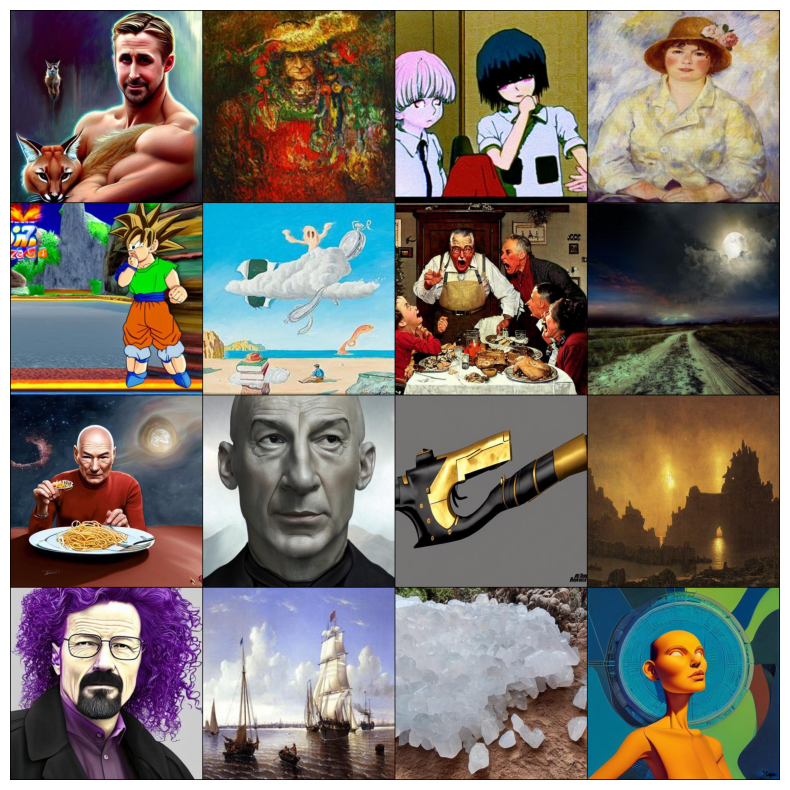

In [14]:
import random
import torchvision
import matplotlib.pyplot as plt


seed = 71
random.seed(seed)

# sample images
samples = random.choices(misclassified, k=16)
samples = test_dataset[samples]['image'].float()
samples = torch.permute(samples, (0, 3, 1, 2))
samples = torchvision.utils.make_grid(samples, nrow=4, padding=2, normalize=True)
samples = torch.permute(samples, (1, 2, 0))

# show
plt.figure(figsize=(10, 10))
plt.imshow(samples)
plt.axis('off')
plt.show()

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified images. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

[Please put your write up here]
1. [The model link on Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model)
2. We can do the following:
    - Add more layers
    - Use data augmentation techniques
    - Use residual blocks
    - Implement complex architecture 

# 2. Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/datasets/sadikaljarif/fake-news-detection-dataset-english (if you'd like, you can also look at fake news datasets in other languages, which are available on the Huggingface Hub)
* Develop an NLP model for classification that uses a pretrained language model and the *text* of the article. It should *NOT* use the URL
* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* *Answer the following question*: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

[Please put your write up here]

# 3. Deep RL / Robotics

**RL for Classical Control:** Using any of the [classical control](https://github.com/openai/gym/blob/master/docs/environments.md#classic-control) environments from OpenAI's `gym`, implement a deep NN that learns an optimal policy which maximizes the reward of the environment.

* Describe the NN you implemented and the behavior you observe from the agent as the model converges (or diverges).
* Plot the reward as a function of steps (or Epochs).
Compare your results to a random agent.
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.
* (Optional) [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.


You may use any frameworks you like, but you must implement your NN on your own (no pre-defined/trained models like [`stable_baselines`](https://stable-baselines.readthedocs.io/en/master/)).

You may use any simulator other than `gym` _however_:
* The environment has to be similar to the classical control environments (or more complex like [`robosuite`](https://github.com/ARISE-Initiative/robosuite)).
* You cannot choose a game/Atari/text based environment. The purpose of this challenge is to demonstrate an understanding of basic kinematic/dynamic systems.

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* (Optional) link to the model on Hugging Face Hub: 
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.

[Please put your write up here]

# 4. Theory / Linear Algebra 

**Implement Contrastive PCA** Read [this paper](https://www.nature.com/articles/s41467-018-04608-8) and implement contrastive PCA in Python.

* First, please discuss what kind of dataset this would make sense to use this method on
* Implement the method in Python (do not use previous implementations of the method if they already exist)
* Then create a synthetic dataset and apply the method to the synthetic data. Compare with standard PCA.


**Write up**: Discuss what kind of dataset it would make sense to use Contrastive PCA

[Please put your write up here]

In [ ]:
### WRITE YOUR CODE HERE

# 5. Systems

**Inference on the edge**: Measure the inference times in various computationally-constrained settings

* Pick a few different speech detection models (we suggest looking at models  on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads))
* Simulate different memory constraints and CPU allocations that are realistic for edge devices that might run such models, such as smart speakers or microcontrollers, and measure what is the average inference time of the models under these conditions 
* How does the inference time vary with (1) choice of model (2) available system memory (3) available CPU (4) size of input?

Are there any surprising discoveries? (Note that this coding challenge is fairly open-ended, so we will be considering the amount of effort invested in discovering something interesting here).

In [ ]:
### WRITE YOUR CODE HERE

**Write up**: What surprising discoveries do you see?

[Please put your write up here]